In [27]:

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio 
import rasterio.plot
from rasterio.mask import mask
from rasterio.plot import show
import fiona
import pyproj
import numpy 
import matplotlib 

In [28]:
#load SuperView data
#%%
superview_path = 'C:/Users/jerry.guan/OneDrive - Shell/Data/Superview-1/20190726_111417_SV1-03_50cm_RD_11bit_RGBI_Zeewolde/20190726_111417_SV1-03_50cm_RD_11bit_RGBI_Zeewolde.tif'
# with rasterio.open(superview_path) as spv:
#     oviews = spv.overviews(1)
#     oview = oviews[-1]
#     print('Decimation factor = {}'.format(oview))
#     thumbnail = spv.read(1,out_shape=(1, int(spv.height // oview), int(spv.width // oview)))
#     # print(spv.profile)

# print('array type: ',type(thumbnail))
# print(thumbnail)


# plt.imshow(thumbnail)
# plt.colorbar()
spv = rasterio.open(superview_path)

#assign each band
#spv_band1 = spv.read(1)


In [33]:
#read shapefile
replantation_path = 'C:/Users/jerry.guan/OneDrive - Shell/InterResult/legger_Hulkestein_Singlepart.shp'
Hulkestein = gpd.read_file(replantation_path)
Hulkestein = Hulkestein.to_crs(crs=spv.crs.data)
def getFeatures(gdf):
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

coords = getFeatures(Hulkestein)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[157586.21299999952, 474585.7700000033], [157564.4299999997, 474583.41500000656], [157528.1150000021, 474576.88000001013], [157526.20700000226, 474583.242999997], [157525.3120000027, 474586.2289999947], [157512.62500000373, 474628.53700001165], [157510.82299999893, 474634.5450000018], [157516.9990000017, 474635.65600000694], [157517.01970000193, 474635.6597000025], [157567.763000004, 474644.79399999976], [157566.85500000045, 474644.52600000054], [157567.2030000016, 474643.47199999914], [157582.18499999866, 474597.9960000068], [157585.12800000235, 474589.0629999973], [157586.21299999952, 474585.7700000033]]]}]


In [39]:
#check coordinate reference system between two data source
print('SuperView Project: ', spv.crs)

print('Hulkestein Project: ', Hulkestein.crs)

SuperView Project:  PROJCS["unnamed",GEOGCS["Amersfoort",DATUM["Amersfoort",SPHEROID["Bessel 1841",6377397.155,299.152812800003,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6289"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4289"]],PROJECTION["Oblique_Stereographic"],PARAMETER["latitude_of_origin",52.1561605555556],PARAMETER["central_meridian",5.38763888888889],PARAMETER["scale_factor",0.9999079],PARAMETER["false_easting",155000],PARAMETER["false_northing",463000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Hulkestein Project:  +proj=sterea +lat_0=52.1561605555556 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs +type=crs


In [34]:
with rasterio.open(superview_path) as img:
    clipped, transform = mask(img, coords, crop=True)

print(clipped.shape)

(4, 137, 152)


In [36]:
out_meta = spv.meta.copy()
#update metada with new, clipped mosaic's boundaries
out_meta.update({"transform": transform,
    "height":clipped.shape[1],"width": clipped.shape[2]})

#write the clipped and cropped dataset to a new Geotiff
with rasterio.open('clipped_spv.tif','w',**out_meta) as dst:
    dst.write(clipped)


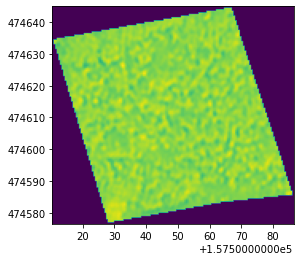

<AxesSubplot:>

In [38]:
clipped_spv = rasterio.open("clipped_spv.tif")
show(clipped_spv)

In [42]:
from rasterio.warp import calculate_default_transform, reproject

#define our target CRS 
target_crs = 'EPSG:4289'

In [43]:
#calculate a transform and new dimensions using current CRS and dimensions
transform,width,height = calculate_default_transform(clipped_spv.crs,target_crs, clipped_spv.width,clipped_spv.height,*clipped_spv.bounds)

In [46]:
metadata = clipped_spv.meta.copy()

#change the CRS 
metadata.update({'crs':target_crs,'transform':transform,'width':width,'height':height})

In [47]:
# apply the transform & metadata to perform the reprojection
# here we're saving the output to a new 'clipped_4326.tif' file
with rasterio.open('clipped_4326.tif', 'w', **metadata) as reprojected:
    for band in range(1, clipped_spv.count + 1):
        reproject(
            source=rasterio.band(clipped_spv, band),
            destination=rasterio.band(reprojected, band),
            src_transform=clipped_spv.transform,
            src_crs=clipped_spv.crs,
            dst_transform=transform,
            dst_crs=target_crs
        )

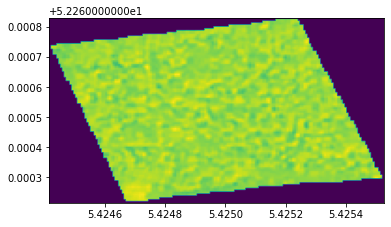

<AxesSubplot:>

In [48]:

# take a look at our clipped & reprojected dataset
reproj = rasterio.open("clipped_4326.tif")
show(reproj)